In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [67]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [87]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ (n_embd * block_size) ** 0.5
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # small initialization
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # small initialization
b2 = torch.randn(vocab_size,                      generator=g) * 0 # zero initialization

bngain = torch.ones((1, n_hidden)) # batch normalization gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization bias
bnmean_running = torch.zeros((1, n_hidden)) # running mean of the batch norm
bnstd_running = torch.ones((1, n_hidden)) # running standard deviation of the batch norm

parameters = [C, W1,  W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [89]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # batch normalization layer 
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters: p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break
  

      0/ 200000: 2.1217
  10000/ 200000: 2.0989
  20000/ 200000: 2.3377
  30000/ 200000: 2.3451
  40000/ 200000: 2.4895
  50000/ 200000: 1.9879
  60000/ 200000: 2.2636
  70000/ 200000: 2.1880
  80000/ 200000: 2.0735
  90000/ 200000: 2.0768
 100000/ 200000: 2.1153
 110000/ 200000: 1.7320
 120000/ 200000: 1.9312
 130000/ 200000: 1.7534
 140000/ 200000: 1.9902
 150000/ 200000: 1.5777
 160000/ 200000: 1.8954
 170000/ 200000: 2.1763
 180000/ 200000: 1.9973
 190000/ 200000: 1.9562


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

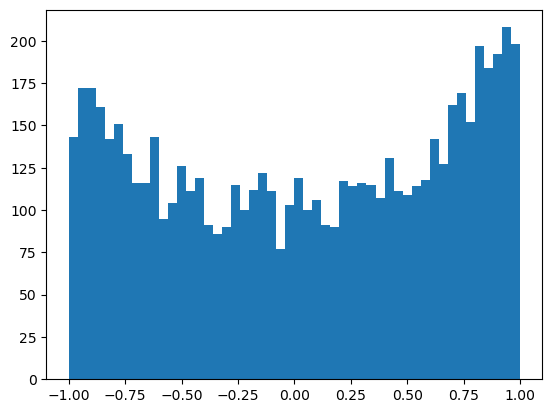

In [52]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367116, -3.6200974 , -3.47652364, -3.33294988, -3.18937612,
        -3.04580235, -2.90222859, -2.75865483, -2.61508107, -2.47150731,
        -2.32793355, -2.18435979, -2.04078603, -1.89721227, -1.75363851,
        -1.61006474, -1.46649098, -1.32291722, -1.17934346, -1.0357697 ,
        -0.89219594, -0.74862218, -0.60504842, -0.46147466, -0.3179009 ,
        -0.17432714, -0.03075337,  0.11282039,  0.25639415,  0.39996791,
         0.54354167,  0.68711543,  0.83068919,  0.97426295,  1.11783671,
         1.26141047,  1.40498424,  1.548558  ,  1.69213176,  1.83570552,
         1.97927928,  2.12285304,  2.2664268 ,  2.41000056,  2.55357432,
 

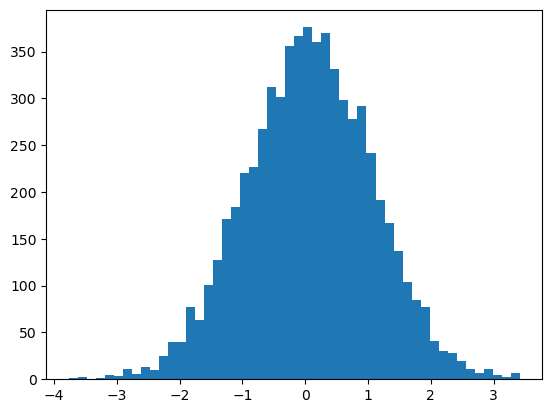

In [53]:
plt.hist(hpreact.view(-1).tolist(), 50)

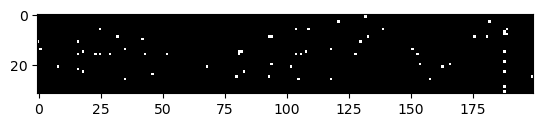

In [54]:
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [22]:
-torch.tensor(1/27).log()

tensor(3.2958)

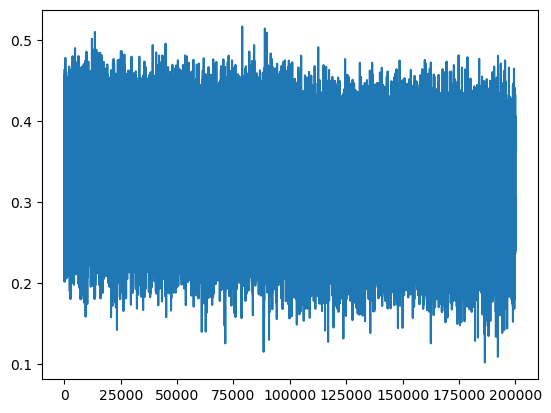

In [90]:
plt.plot(lossi)

In [80]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [81]:
bnmean

tensor([[-2.1171,  0.5151, -1.0355,  1.1472,  0.6457,  0.3297,  1.8942, -0.4451,
          0.7888,  2.1818, -2.5897, -2.1385, -0.5529, -0.8029, -0.5847, -0.7731,
          0.3468, -1.7540, -0.5939,  1.5619, -0.5667, -0.2291, -0.3648,  0.2870,
          1.2614,  1.7647,  1.3128,  0.3417,  1.0104,  1.6196, -0.6550, -0.9392,
          0.7127, -0.2059,  0.4415, -0.9259, -1.5156,  0.2045,  0.0871,  0.9062,
          0.1703, -1.0021, -0.5580, -0.1233,  0.8608,  0.2529,  0.9942, -1.4480,
          2.0848,  1.2254,  1.4297,  0.1473,  2.2828,  0.7296,  0.9589, -2.5080,
         -0.3612,  0.7972,  2.2360, -1.4968, -0.2657,  0.9916,  0.8040,  0.4386,
          1.2355,  1.3860, -0.2402,  1.4185, -0.5125, -0.2784,  0.0867,  0.6063,
          0.6205, -1.8870, -2.3069,  0.4171,  1.2391, -0.0953,  0.2780,  0.4433,
         -0.2146,  1.2354,  1.2541,  1.0807,  0.3930, -0.6237, -0.8048, -0.0700,
          2.7139, -0.2097, -0.9276,  1.2881, -0.9340, -1.0923, -1.5613,  0.5643,
         -0.1310, -0.3507, -

In [82]:
bnmean_running

tensor([[-2.1052,  0.5062, -1.0491,  1.1578,  0.6408,  0.3288,  1.9093, -0.4267,
          0.7898,  2.1971, -2.5673, -2.1399, -0.5380, -0.8096, -0.5738, -0.7688,
          0.3398, -1.7605, -0.5851,  1.5557, -0.5555, -0.2153, -0.3661,  0.2812,
          1.2576,  1.7618,  1.3153,  0.3318,  1.0108,  1.6235, -0.6543, -0.9489,
          0.7128, -0.2062,  0.4278, -0.9170, -1.5013,  0.2250,  0.0677,  0.9039,
          0.1810, -0.9840, -0.5668, -0.1117,  0.8465,  0.2390,  0.9984, -1.4425,
          2.0987,  1.2389,  1.4190,  0.1478,  2.2976,  0.7490,  0.9491, -2.4884,
         -0.3599,  0.7966,  2.2169, -1.4949, -0.2631,  0.9898,  0.8070,  0.4637,
          1.2416,  1.3894, -0.2368,  1.4214, -0.5096, -0.2794,  0.0982,  0.5819,
          0.6431, -1.8995, -2.3053,  0.4097,  1.2177, -0.1014,  0.2751,  0.4428,
         -0.2150,  1.2323,  1.2707,  1.0634,  0.3814, -0.6506, -0.8102, -0.0687,
          2.7042, -0.2174, -0.9457,  1.2814, -0.9254, -1.0830, -1.5526,  0.5789,
         -0.1294, -0.3462, -

In [83]:
bnstd

tensor([[2.2111, 2.0414, 2.1088, 2.1512, 2.0430, 2.3066, 2.2349, 2.1786, 2.3096,
         2.0607, 2.3993, 2.1107, 2.2468, 1.8811, 1.9327, 2.8541, 2.2610, 1.9206,
         2.2061, 2.5271, 2.3753, 2.2468, 1.9632, 2.2141, 2.2025, 2.1244, 2.0631,
         2.5196, 2.5540, 2.4630, 1.6658, 2.0516, 2.3855, 2.0303, 1.9773, 1.9207,
         2.5583, 2.0752, 2.1791, 1.7478, 2.0707, 1.9989, 2.5697, 1.8804, 2.3541,
         2.2724, 2.1521, 2.6761, 2.2714, 2.2614, 1.9797, 1.9141, 2.0429, 1.9122,
         2.2140, 2.2613, 2.0620, 2.1825, 2.8875, 2.1817, 2.1603, 2.0079, 1.9846,
         2.2921, 2.3623, 2.1728, 2.0889, 2.4023, 1.8486, 2.0643, 2.1030, 1.9756,
         2.1791, 2.0125, 2.0122, 1.7283, 2.4878, 2.3244, 2.0167, 2.2652, 2.0425,
         1.9840, 2.0905, 2.3703, 2.2210, 2.3089, 2.1877, 2.4027, 2.4627, 2.7662,
         2.0901, 1.8525, 2.0730, 1.8779, 1.8429, 2.1629, 2.0939, 1.9083, 2.1869,
         2.2990, 2.0871, 2.2006, 2.1410, 2.2367, 1.9944, 2.2457, 1.8839, 2.1320,
         1.8811, 2.1227, 2.2

In [84]:
bnstd_running

tensor([[2.2030, 2.0195, 2.0998, 2.1248, 2.0291, 2.2906, 2.2242, 2.1432, 2.2934,
         2.0363, 2.3802, 2.0948, 2.2339, 1.8748, 1.9036, 2.8334, 2.2508, 1.9044,
         2.1870, 2.5079, 2.3591, 2.2196, 1.9478, 2.2009, 2.1996, 2.1080, 2.0470,
         2.4871, 2.5198, 2.4299, 1.6562, 2.0355, 2.3704, 2.0184, 1.9683, 1.8921,
         2.5442, 2.0547, 2.1625, 1.7325, 2.0561, 1.9847, 2.5524, 1.8721, 2.3298,
         2.2723, 2.1270, 2.6336, 2.2524, 2.2493, 1.9543, 1.8907, 2.0204, 1.8932,
         2.1920, 2.2426, 2.0363, 2.1669, 2.8736, 2.1454, 2.1583, 2.0002, 1.9726,
         2.2755, 2.3424, 2.1529, 2.0752, 2.3844, 1.8329, 2.0456, 2.0832, 1.9610,
         2.1782, 1.9896, 2.0066, 1.7171, 2.4608, 2.3095, 2.0104, 2.2371, 2.0314,
         1.9588, 2.0787, 2.3496, 2.1894, 2.2924, 2.1731, 2.3748, 2.4559, 2.7414,
         2.0677, 1.8271, 2.0672, 1.8647, 1.8210, 2.1454, 2.0712, 1.8953, 2.1554,
         2.2833, 2.0686, 2.1829, 2.1135, 2.2232, 1.9766, 2.2291, 1.8600, 2.1242,
         1.8527, 2.0952, 2.1

In [91]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  #+ b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std() + bnbias
  hpreact = bngain *  (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden) 
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.151854991912842
val 2.2046358585357666


In [74]:
# sample from

g = torch.Generator ().manual_seed (2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]# (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context [1:] + [ix]
        out.append (ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

chrishfatufillissemrix.
taty.
salfr.
kejlahntlfagdrystopheriffergkirrchrishivsomiybh.
bluffiriquijn.
sulie.
sindelianaurfagdifraxixfkirinissandel.
faisleghna.
jesslyah.
asmberthissa.
saquovozswylojnnikotifrendepraadlie.
shoussicorgiorgnir.
quiliannarek.
quiloqifranteventreeftotygbrcodestrpycessly.
kercenzahnnyxaddrik.
sasdanikotalden.
bry.
quilto.
rohk.
krishnnekirrenzlillyz.


In [19]:
out

[11, 1, 5, 12, 0]